In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from custom_nets import LayeredLSTM
import matplotlib.pyplot as plt
from random import shuffle

%matplotlib-inline

UsageError: Line magic function `%matplotlib-inline` not found.


In [2]:
with open('trump_tweets.txt', 'r') as file:
    data = file.readlines()
# categories = set(_ for d in data for _ in d)
categories = ('\n', ' ', '!', '"', '#', '$', '%', '&', '\'', '(', ')', '+', ',', '-', '.', '/',
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@',
              'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
              'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e',
              'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
              'v', 'w', 'x', 'y', 'z', '<END>')
for i in range(len(data)):
    data[i] = data[i].strip()
    chrs = set(data[i])
    for erase in chrs - set(categories):
        data[i] = data[i].replace(erase, '')

n_letters = len(categories)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
epoch 0 done
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
epoch 1 done
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
epoch 2 done
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
epoch 3 done
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
epoch 4 done
1240 730


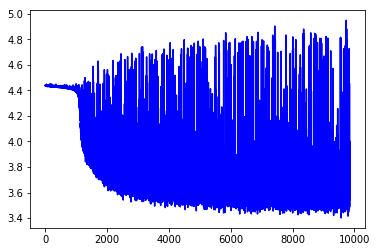

In [8]:
def input_target_pair(s):
    if s in categories:  # inputting letter by letter
        inp = torch.zeros(1, 1, n_letters)
        inp[0, 0, categories.index(s)] = 1
        return inp
    inp = torch.zeros(len(s), 1, n_letters)
    tar = []
    for i, c in enumerate(s):
        if i > 0:
            tar.append(categories.index(c))
        inp[i, 0, categories.index(c)] = 1
    tar.append(len(categories) - 1)
    tar = torch.LongTensor(tar)
    tar.unsqueeze_(-1)
    return inp, tar

# net = LSTM1(n_letters, n_letters)
net = LayeredLSTM(n_letters, n_letters, num_layers=3)
# net2 = nn.LSTM(n_letters, n_letters)
criterion = nn.NLLLoss()
lr = 0.000005
optimizer = optim.Adam(net.parameters(), lr=lr)

losses = []
loss_ave = []
# losses2 = []

fitting, not_fitting = [], []
for epoch in range(5):
    count = 0
    shuffle(data)
    for d in data:
        seq_len = len(d)
        input_tensor, target_tensor = input_target_pair(d)
        # tar2 = torch.zeros(seq_len, n_letters)
        # tar2[range(seq_len), target_tensor[:, 0]] = 1
        # hidden_state, cell_state = net.init_states()
        # hs2, cs2 = hidden_state.view(1, 1, -1), cell_state.view(1, 1, -1)
        net.init_new_seq()
        
        optimizer.zero_grad()
        # net.zero_grad()
        # net2.zero_grad()
        
        loss = None
        
        # o2, _ = net2(input_tensor, (hs2, cs2))
        # loss2 = criterion(o2, torch.max(target_tensor, 1)[1])
        
        for i in range(seq_len):
            output = net(input_tensor[i])
            l = criterion(output, target_tensor[i])
            if loss is None:
                loss = l
            else:
                loss += l
        
        if loss is None:
            continue
        
        loss.backward()
        # loss2.backward()
        
        optimizer.step()
        # for p in net.parameters():
        #     p.data.add_(-lr, p.grad.data)
        # for p in net2.parameters():
        #     p.data.add_(-lr, p.grad.data)
        
        losses.append(loss.item() / input_tensor.size(0))
        loss_ave.append(sum(losses) / len(losses))
        # losses2.append(loss2.item() / input_tensor.size(0))
        
        count += 1
        if not count % 30:
            print('|', end='')
        
        if epoch == 4:
            if losses[-1] < 3.6:
                fitting.append(d)
            else:
                not_fitting.append(d)
    print('\nepoch {} done'.format(epoch))

# for i in range(1, len(losses) // len(data)):
#     plt.axvline(x=len(data)*i, color='red')
plt.plot(losses, color='blue')
plt.plot(loss_ave, color='red')
plt.show()
# for i in range(1, len(losses) // len(data)):
#     plt.axvline(x=len(data)*i, color='red')
# plt.plot(losses2, color='blue')
# plt.show()
print(len(fitting), len(not_fitting))

In [19]:
print(not_fitting[-3:])
print(fitting[-3:])

['The WTO is BROKEN when the worlds RICHEST countries claim to be developing countries to avoid WTO rules and get special treatment. NO more!!! Today I directed the U.S. Trade Representative to take action so that countries stop CHEATING the system at the expense of the USA!', 'I donate 100% of my Presidents salary, $400,000, back to our Country, and feel very good about it!', '100% Confirmed!']
['Just heard that Sean Spicer will be on Dancing with the Stars. He will do great. A terrific person who loves our Country dearly!', '....bad Economic times, the worse the better, anything to make my Election more difficult to win. Well, we are having very good meetings, the Leaders are getting along very well, and our Country, economically, is doing great - the talk of the world!', 'A brave former fighter jet pilot and warrior, Senator Martha McSally of Arizona has done an outstanding job in D.C., and is fully supportive of our agenda  she is with us all the way....']


In [6]:
# make one sample
def sample(start_letter=categories[-1], max_length=280):
    rtn = '' if start_letter == categories[-1] else start_letter
    with torch.no_grad():  # no need to track history in sampling
        net.init_new_seq()
        input_tensor = input_target_pair(start_letter)
        for _ in range(max_length):
            output = net(input_tensor[0])
            top = output.topk(1)
            topi = top[1][0][0]
            letter = categories[topi]
            rtn += letter
            if topi == n_letters - 1:
                break
            input_tensor = input_target_pair(letter)
        return rtn

s = sample(start_letter='A')
print(len(s))
print(s)
print(set(s))

(tensor([[-4.1663]]), tensor([[1]]))
(tensor([[-3.8872]]), tensor([[1]]))
(tensor([[-3.6304]]), tensor([[1]]))
(tensor([[-3.4341]]), tensor([[1]]))
(tensor([[-3.3150]]), tensor([[1]]))
(tensor([[-3.2544]]), tensor([[1]]))
(tensor([[-3.2263]]), tensor([[1]]))
(tensor([[-3.2134]]), tensor([[1]]))
(tensor([[-3.2072]]), tensor([[1]]))
(tensor([[-3.2040]]), tensor([[1]]))
(tensor([[-3.2023]]), tensor([[1]]))
(tensor([[-3.2013]]), tensor([[1]]))
(tensor([[-3.2007]]), tensor([[1]]))
(tensor([[-3.2003]]), tensor([[1]]))
(tensor([[-3.2001]]), tensor([[1]]))
(tensor([[-3.1999]]), tensor([[1]]))
(tensor([[-3.1997]]), tensor([[1]]))
(tensor([[-3.1997]]), tensor([[1]]))
(tensor([[-3.1996]]), tensor([[1]]))
(tensor([[-3.1995]]), tensor([[1]]))
(tensor([[-3.1995]]), tensor([[1]]))
(tensor([[-3.1995]]), tensor([[1]]))
(tensor([[-3.1994]]), tensor([[1]]))
(tensor([[-3.1994]]), tensor([[1]]))
(tensor([[-3.1994]]), tensor([[1]]))
(tensor([[-3.1994]]), tensor([[1]]))
(tensor([[-3.1994]]), tensor([[1]]))
(